In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

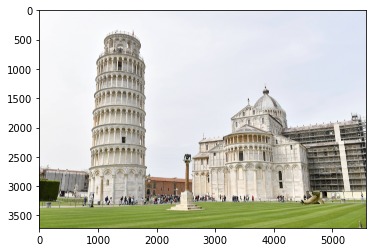

In [12]:
pizza = cv2.imread('./images/pizza.jpg')

plt.imshow(pizza)